<a href="https://colab.research.google.com/github/ANTTAY001/EEE4022-Final-Year-Project/blob/main/TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Utility Functions**

In [3]:
import pandas as pd
import nltk
from nltk.corpus import movie_reviews, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import pandas as pd
import numpy as np
import json

#Loading additional helper functions not shown here but provided in the folder
#!cp /content\drive/My Drive\4th year - 2020/Final Year Project - Personal\18 10 2020_Method/Classification_Models\nlp_utils_news.ipynb .
#!python nlp_utils_news.ipynb
#!cp "/content/drive/My Drive/4th year - 2020/Final Year Project - Personal/18 10 2020_Method/Classification_Models/nlp_utils_news.py" .
#from nlp_utils_news import *


'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

**Preprocess data**

In [5]:
def preprocess_text(text):
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stop words
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords

**k-fold cross-validation performance**

In [21]:
from timeit import default_timer as timer

def get_accuracy(x_train,y_train,model_dict):

  model_name,clf_score_means,clf_score_std,time_elapsed = [],[],[],[]
  for k,v in model_dict.items(): 
    model_name.append(k)
    clf = v
    start = timer()
    clf_score = cross_val_score(clf, x_train, y_train, cv=10)
    end = timer()
    clf_score_means.append(clf_score.mean())
    clf_score_std.append(clf_score.std() * 2)
    time_elapsed.append(end - start) 

    model_comparison_df = pd.DataFrame([model_name, clf_score_means, clf_score_std,time_elapsed]).T
    model_comparison_df.columns = ['model_name', 'accuracy_score', 'std','time_elapsed']
    model_comparison_df = model_comparison_df.sort_values(by='accuracy_score', ascending=False)
    #print(k)
    #print(end - start) 
  return model_comparison_df


**Classification Model Dictionary**

In [17]:
model_dict = { 'SVM' : svm.SVC(decision_function_shape='ovo'), # SVM for multi-class classification
              'Random Forest': RandomForestClassifier(random_state=123),
              'K Nearest Neighbors': KNeighborsClassifier(),
              'Logistic Regression' : LogisticRegression(multi_class='ovr'),
              'Dummy' : DummyClassifier(random_state=3) #sklearn’s dummy classifier which is just random chance as a baseline
              }

# **Splitting the data: train and validation sets**

In [9]:
# READ IN TRAINING DATA
ds = pd.read_csv("/content/drive/My Drive/4th year - 2020/Final Year Project - Personal/29 10 2020/Training_Data/Merged_NEW.csv") 
da = ds.sample(frac=1) #shuffle the order of the data
da.to_csv('/content/drive/My Drive/4th year - 2020/Final Year Project - Personal/29 10 2020/Training_Data/Merged_NEW_SHUFFLED.csv')

# 80/20 split
# TRAINING
df = pd.read_csv('/content/drive/My Drive/4th year - 2020/Final Year Project - Personal/29 10 2020/Training_Data/Merged_NEW_SHUFFLED.csv')

# Encode classes with numeric labels
label_num_dict = {'Sepsis': 0,
                  'Myocardial Infarcation': 1,
                  'Cardiac Arrest': 2}

df['disease'] = df['disease'].replace(label_num_dict)

# TRAINING 
df_train = df

# TESTING/VALIDATION
df_test = pd.read_csv('/content/drive/My Drive/4th year - 2020/Final Year Project - Personal/29 10 2020/Testing_Data/Merged_VALIDATION_NEW.csv')
df_test['disease'] = df_test['disease'].replace(label_num_dict)
df_test = df_test.sample(frac = 1)



In [10]:
X_train = df_train['description']
X_test = df_test['description']
y_train = df_train['disease']
y_test = df_test['disease']

train_example = X_train[:1] # for report example

print(train_example)
print(f'Train dimensions: {X_train.shape, y_train.shape}')
print(f'Test dimensions: {X_test.shape, y_test.shape}')
# Check out target distribution
print(y_train.value_counts())
print(y_test.value_counts())

0    yes hi yes need an ambulance to pick hawaii hi...
Name: description, dtype: object
Train dimensions: ((1077,), (1077,))
Test dimensions: ((20,), (20,))
2    378
0    364
1    335
Name: disease, dtype: int64
2    8
0    7
1    5
Name: disease, dtype: int64


# **Checking if train and validation data sets come from the same distribution**

In [13]:
# Adverserial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer

def adversarial_validation(X, Y, n_splits = 10):
    
    # Combine both datasets
    sparse_merge = sparse.vstack((X, Y))
    
    # Label the datasets
    y = np.array([0 for _ in range(X.shape[0])] + [1 for _ in range(Y.shape[0])])
    
    # Do 10 Fold CV 
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)

    lr_auc = np.array([])
    rf_auc = np.array([])
    for train_idx, test_idx in kfold.split(sparse_merge, y):
    
        #Run Log Reg
        x_train, y_train = sparse_merge[train_idx], y[train_idx]
        x_test, y_test = sparse_merge[test_idx], y[test_idx]
        
        log_reg = SGDClassifier(random_state=3, loss='log')
        log_reg.fit(x_train, y_train)
        y_test_prob = log_reg.predict_proba(x_test)[:,1]
        lr_auc = np.append(lr_auc, roc_auc_score(y_test, y_test_prob))
        
        # Run RF
        rf =  DecisionTreeClassifier(random_state=3)
        rf.fit(x_train, y_train)
        y_test_prob = rf.predict_proba(x_test)[:,1]
        rf_auc = np.append(rf_auc, roc_auc_score(y_test, y_test_prob))

    
    # Display results
    print('Logisitic Regression AUC : {:.3f}'.format(lr_auc.mean()))
    print('Decision Tree AUC : {:.3f}'.format(rf_auc.mean()))  

bow = CountVectorizer()
x_train = bow.fit_transform(X_train)
x_test = bow.transform(X_test)
adversarial_validation(x_train, x_test)  

Logisitic Regression AUC : 0.588
Decision Tree AUC : 0.598


# **WordClouds**

**Sepsis**

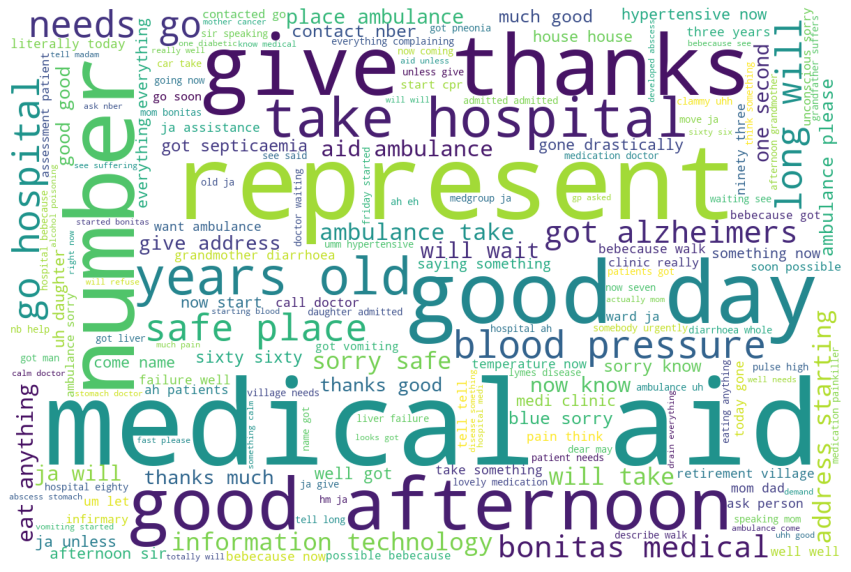

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

all_stopwords=[]
text = ' '.join(ds[ds.disease == 'Sepsis'].description.values)
text_tokens = word_tokenize(text)

add = ['thank','need','bye','yes','okay','atomic','hello','hi']
all_stopwords.extend(add)

tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
words = ' '.join(tokens_without_sw)

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(words)

plt.figure(figsize = (15, 12)) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show() 


**Myocardial Infarction**

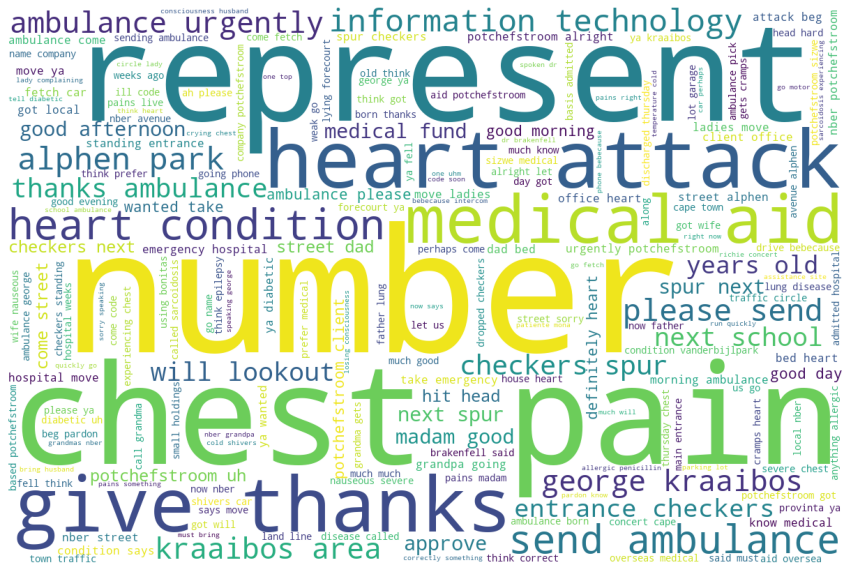

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

all_stopwords=[]
text = ' '.join(ds[ds.disease == 'Myocardial Infarcation'].description.values)
text_tokens = word_tokenize(text)

add = ['thank','need','bye','yes','okay','atomic','hello','hi']
all_stopwords.extend(add)

tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
words = ' '.join(tokens_without_sw)

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(words)

plt.figure(figsize = (15, 12)) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show() 

**Cardiac Arrest**

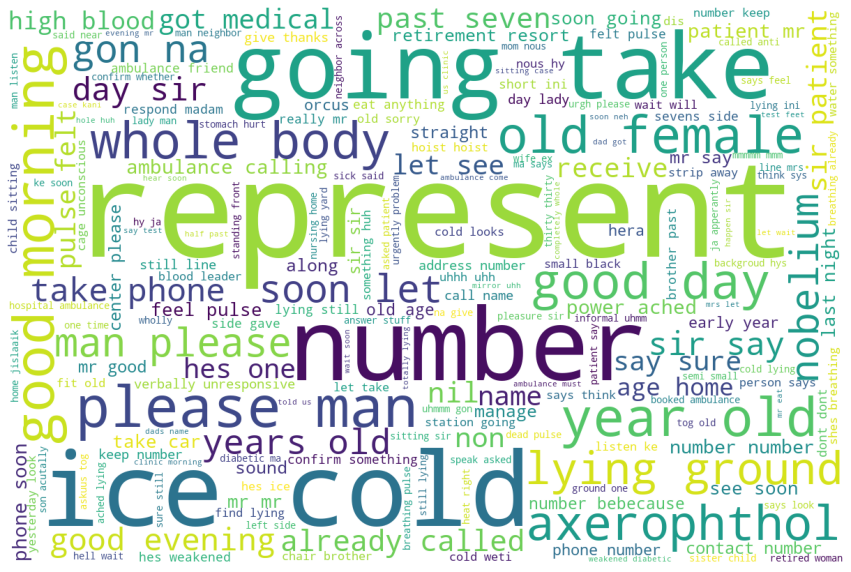

In [ ]:
%matplotlib inline
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

all_stopwords=[]
text = ' '.join(ds[ds.disease == 'Cardiac Arrest'].description.values)
text_tokens = word_tokenize(text)

add = ['thank','need','bye','yes','okay','atomic','hello','hi','uhm','nothing','oky','uh','now','know']
all_stopwords.extend(add)

tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
words = ' '.join(tokens_without_sw)

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(words)

plt.figure(figsize = (15, 12)) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show() 

# **Create TF-IDF features**

In [15]:
# Create an instance of TfidfVectorizer
vectoriser = TfidfVectorizer(analyzer=preprocess_text)

# Fit to the data and transform to feature matrix
X_train_tfidf = vectoriser.fit_transform(X_train)

#normalizer_tfidf = MinMaxScaler()
X_test_tfidf = vectoriser.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1077, 2027)
(20, 2027)


# **Get TF-IDF classification accuracy**

In [22]:
tfidf_only = get_accuracy(X_train_tfidf,y_train,model_dict)
print(tfidf_only)

            model_name accuracy_score  std time_elapsed
0                  SVM           1.00 0.00         4.57
1        Random Forest           1.00 0.00         3.03
2  K Nearest Neighbors           1.00 0.00         0.14
3  Logistic Regression           1.00 0.00         0.64
4                Dummy           0.33 0.12         0.02


# **Predicting on unseen data**

In [23]:
for name,model in model_dict.items():
  pipe = Pipeline([('vectoriser', vectoriser),
                  ('classifier', model )])
  pipe.fit(X_train, y_train)
  y_test_pred = pipe.predict(X_test)
  print(name)
  print("Accuracy: %0.2f" % (accuracy_score(y_test, y_test_pred)))
  

SVM
Accuracy: 0.95
Random Forest
Accuracy: 0.95
K Nearest Neighbors
Accuracy: 0.75
Logistic Regression
Accuracy: 0.95
Dummy
Accuracy: 0.35


# **GridSearchCV**

**SVM**

In [36]:
from sklearn.model_selection import KFold
sgd_clf2 = svm.SVC(decision_function_shape='ovo')
svm_params = {'C' : [10**(x) for x in range(-1,4)],
             'kernel' : ['poly', 'rbf', 'linear'],
             'degree' : [2, 3]}

cv_test= KFold(n_splits=10)
search = GridSearchCV(estimator=sgd_clf2, param_grid=svm_params, cv=cv_test)
search.fit(X_train_tfidf, y_train)  #test_features, y_test)
print(search.best_params_)
print("Cross-validation:")
print(search.best_score_)

pipe = Pipeline([('vectoriser', vectoriser),
                 ('classifier',  search.best_estimator_)],verbose=True) #search.best_estimator_
start_cross = timer()
pipe.fit(X_train, y_train)

y_test_pred = pipe.predict(X_test)
end_cross = timer()
print("Unseen data:")
print("Accuracy: %0.2f" % (accuracy_score(y_test, y_test_pred)))


{'C': 0.1, 'degree': 2, 'kernel': 'poly'}
Cross-validation:
1.0
[Pipeline] ........ (step 1 of 2) Processing vectoriser, total=  12.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.6s
Unseen data:
Accuracy: 0.90


**KNN**

In [35]:
sgd_clf2 = KNeighborsClassifier(n_jobs = -1)
knn_params = { 'n_neighbors' : [3, 5, 7, 9, 15, 31], 
               'weights' : ['uniform', 'distance']
}


search = GridSearchCV(estimator=sgd_clf2, param_grid=knn_params, cv=10)
search.fit(X_train_tfidf, y_train)  #test_features, y_test)

print(search.best_params_)
print("Cross-validation:")
print(search.best_score_)


pipe = Pipeline([('vectoriser', vectoriser),
                 ('classifier',  search.best_estimator_)],verbose=True) #search.best_estimator_
start_cross = timer()
pipe.fit(X_train, y_train)

y_test_pred = pipe.predict(X_test)
end_cross = timer()
print("Unseen data:")
print("Accuracy: %0.2f" % (accuracy_score(y_test, y_test_pred)))



{'n_neighbors': 3, 'weights': 'uniform'}
Cross-validation:
1.0
[Pipeline] ........ (step 1 of 2) Processing vectoriser, total=  12.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Unseen data:
Accuracy: 0.85


**Random Forest**

In [34]:
sgd_clf2 = RandomForestClassifier(n_jobs = -1)
rf_params = { 'n_estimators' : [10, 100, 250, 500, 1000], 
               'max_depth' : [None, 3, 7, 15],
               'min_samples_split' : [2, 5, 15,30]
}

search = GridSearchCV(estimator=sgd_clf2, param_grid=rf_params, cv=10)
search.fit(X_train_tfidf, y_train)  #test_features, y_test)

print(search.best_params_)
print("Cross-validation:")
print(search.best_score_)

pipe = Pipeline([('vectoriser', vectoriser),
                 ('classifier',  search.best_estimator_)],verbose=True) #search.best_estimator_
start_cross = timer()
pipe.fit(X_train, y_train)

y_test_pred = pipe.predict(X_test)
end_cross = timer()
print("Unseen data:")
print("Accuracy: %0.2f" % (accuracy_score(y_test, y_test_pred)))


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}
Cross-validation:
1.0
[Pipeline] ........ (step 1 of 2) Processing vectoriser, total=  12.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.1s
Unseen data:
Accuracy: 0.85


**Logistic Regression**

In [33]:
sgd_clf2 = LogisticRegression()

rf_params= {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}

search = GridSearchCV(estimator=sgd_clf2, param_grid=rf_params, cv=10)
start_cross = timer()
search.fit(X_train_tfidf, y_train)  #test_features, y_test)
print(search.best_params_)
print("Cross-validation:")
print(search.best_score_)

pipe = Pipeline([('vectoriser', vectoriser),
                 ('classifier',  search.best_estimator_)], verbose=True) #search.best_estimator_
pipe.fit(X_train, y_train)

y_test_pred = pipe.predict(X_test)
end_cross = timer()
print("Unseen data:")
print("Accuracy: %0.3f" % (accuracy_score(y_test, y_test_pred)))
#print("Elapsed time:")
#print(end_cross - start_cross)

{'C': 0.03359818286283781, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-validation:
1.0
[Pipeline] ........ (step 1 of 2) Processing vectoriser, total=  12.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.0s
Unseen data:
Accuracy: 0.900


# **SelectKBest - Feature Selection**

In [37]:
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm_notebook
#Lets run a for loop to select the value of K that optimizes F1

f1_scores = []
clf3=SGDClassifier(random_state=3, loss='log')
for k in tqdm_notebook(range(1, X_train_tfidf.shape[1])):
    selector = SelectKBest(k = k)
    train_features_selected = selector.fit_transform(X_train_tfidf, y_train)
    test_features_selected = selector.transform(X_test_tfidf)
    clf_mean = cross_val_score(clf3, train_features_selected, y_train, cv=10)
    f1_scores.append(clf_mean.mean())
f1_scores = np.array(f1_scores)

**Print number of best features**

In [38]:
new_k = np.argmax(f1_scores) + 1
print(new_k)

116


**Best features performance prediction on unseen Data**

In [39]:
from sklearn.feature_extraction import DictVectorizer
selector = SelectKBest(k = new_k)
train_features_selected_TFIDF = selector.fit_transform(X_train_tfidf, y_train)
print(np.asarray(vectoriser.get_feature_names())[selector.get_support()])

test_features_selected_TFIDF = selector.transform(X_test_tfidf)

for name,model in model_dict.items():
  classifier = model
  classifier.fit(train_features_selected_TFIDF, y_train) 
  y_pred = classifier.predict(test_features_selected_TFIDF)

  print(name)
  #print(confusion_matrix(y_test,y_pred))
  # print(classification_report(y_test,y_pred))
  print(accuracy_score(y_test, y_pred))


['aid' 'alphen' 'also' 'answer' 'anything' 'arrange' 'attack' 'base' 'beg'
 'body' 'bonitas' 'brother' 'c' 'cannot' 'case' 'chest' 'closest' 'code'
 'company' 'condition' 'confirm' 'corner' 'dead' 'dementia' 'dis' 'doctor'
 'eat' 'everything' 'father' 'feel' 'female' 'fund' 'get' 'give' 'gonna'
 'h' 'half' 'happen' 'heart' 'hes' 'hm' 'hospital' 'huh' 'husband'
 'hypertension' 'hys' 'ice' 'ill' 'ja' 'kani' 'know' 'ladies' 'last'
 'leader' 'lie' 'line' 'local' 'look' 'man' 'medical' 'minutes' 'mmmmm'
 'mom' 'mother' 'mr' 'n' 'nber' 'need' 'neh' 'night' 'nothing' 'office'
 'okay' 'oky' 'old' 'pain' 'pardon' 'park' 'patient' 'perhaps' 'police'
 'potchefstroom' 'pressure' 'pulse' 'respond' 'response' 'say' 'second'
 'send' 'seventy' 'side' 'sir' 'sit' 'sizwe' 'someone' 'soon' 'sorry'
 'sort' 'start' 'still' 'street' 'strip' 'thank' 'uh' 'uhm' 'uhmm' 'umm'
 'unless' 'vanderbijlpark' 'vomit' 'walk' 'want' 'well' 'woman' 'ya'
 'year']
SVM
0.95
Random Forest
0.85
K Nearest Neighbors
0.8
Logisti

**Cross Validation**

In [40]:
get_accuracy(train_features_selected_TFIDF, y_train, model_dict)

,model_name,accuracy_score,std,time_elapsed
0,SVM,1.00,0.00,0.40
1,Random Forest,1.00,0.00,2.26
2,K Nearest Neighbors,1.00,0.00,0.12
3,Logistic Regression,1.00,0.00,0.46
4,Dummy,0.33,0.12,0.02
